# Build and Backtest Strategic Asset Allocation (SAA) Strategy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# Formats Dataframes
pd.options.display.float_format = '{:,.2%}'.format

## <em><span style='color:Blue'>Optimization Function</span></em>

In [ ]:
def mean_var_optimize(ret1, ret2, std1, std2, correl12, risk_tol):
    # Find optimal weights

    wgt1 = (risk_tol*(ret1-ret2) + std2**2 - std1*std2*correl12
              )/(std1**2 + std2**2 - 2*std1*std2*correl12)

    wgt2 = 1-wgt1
    wgt_tot = wgt1 + wgt2

    print(f'Optimal portfolio weight for stocks = {wgt1:.2%}')
    print(f'Optimal portfolio weight for bonds = {wgt2:.2%}')
    print(f'Total = {wgt_tot:.2%}')
    
    return wgt1, wgt2


## <em><span style='color:Blue'>Performance Measurement Function</span></em>

In [ ]:
def perform_measure():
    # Training Data
    df_train_results = df_train.describe().transpose()[['mean', 'std']]
    df_train_results['Sharpe ratio'] = (df_train_results['mean']-df_train_results.loc['Tbill','mean'])/df_train_results['std']
    df_train_results['geomean'] = stats.gmean(df_train+1)-1
    # Test Data
    df_test_results = df_test.describe().transpose()[['mean', 'std']]
    df_test_results['Sharpe ratio'] = (df_test_results['mean']-df_test_results.loc['Tbill','mean'])/df_test_results['std']
    df_test_results['geomean'] = stats.gmean(df_test+1)-1
    
    return df_train_results, df_test_results 


## Import Data

In [ ]:
df = pd.read_excel(r'Data - Build and Backtest Strategic Asset Allocation (SAA) Strategy.xls')

In [ ]:
df.set_index('Year', inplace=True)
df

,SP500,Tbill,Tbond
Year,,,
1928,43.81%,3.08%,0.84%
1929,-8.30%,3.16%,4.20%
1930,-25.12%,4.55%,4.54%
1931,-43.84%,2.31%,-2.56%
1932,-8.64%,1.07%,8.79%
...,...,...,...
2017,21.61%,0.93%,2.80%
2018,-4.23%,1.94%,-0.02%
2019,31.21%,1.55%,9.64%


In [ ]:
df_cumret = (1+df).cumprod()

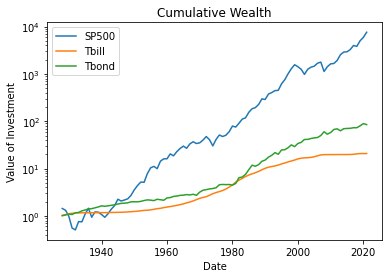

In [ ]:
df_cumret.plot(logy=True, title='Cumulative Wealth', xlabel='Date', ylabel='Value of Investment');

## <font color='red'>*Note that stocks strongly outpace bonds and cash.* </font>

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SP500,"9,400.00%",11.82%,19.46%,-43.84%,-1.17%,14.52%,25.72%,52.56%
Tbill,"9,400.00%",3.33%,3.04%,0.03%,0.68%,2.94%,5.05%,14.03%
Tbond,"9,400.00%",5.11%,7.68%,-11.12%,0.86%,3.28%,8.71%,32.81%


## Split Data into Train and Test Datasets

In [ ]:
df_train = df.loc[:1999].copy()

In [ ]:
df_test = df.loc[2000:].copy()

## Create Capital Market Assumptions (CMAs)
Using historical data from Train dataset

In [ ]:
exp_ret = np.array([df.SP500.mean(), df.Tbond.mean()])
exp_ret

array([0.11820536, 0.0511044 ])

In [ ]:
exp_stdev = np.array([df.SP500.std(), df.Tbond.std()])
exp_stdev

array([0.19460547, 0.07679877])

In [ ]:
corr_stk_bnd = df.SP500.corr(df.Tbond)
corr_stk_bnd

-0.023264487731935173

## Solve for Optimal Portfolio

In [ ]:
risk_tol = .3

# Call mean_var_optimize function
wgt_stk, wgt_bnd = mean_var_optimize(exp_ret[0], exp_ret[1], exp_stdev[0], exp_stdev[1], corr_stk_bnd, risk_tol)

Optimal portfolio weight for stocks = 59.32%
Optimal portfolio weight for bonds = 40.68%
Total = 100.00%


## Calculate Portfolio Returns

In [ ]:
df_train['Optimal_Portfolio'] = wgt_stk*df.SP500 + wgt_bnd*df.Tbond

In [ ]:
df_test['Optimal_Portfolio'] = wgt_stk*df.SP500 + wgt_bnd*df.Tbond

In [ ]:
df_train['Equal_Portfolio'] = .5*df.SP500 + .5*df.Tbond

In [ ]:
df_test['Equal_Portfolio'] = .5*df.SP500 + .5*df.Tbond

## Calculate Performance Statistics

In [ ]:
df_train_results, df_test_results = perform_measure()

#### *Train Dataset*

In [ ]:
df_train_results

,mean,std,Sharpe ratio,geomean
SP500,12.68%,20.01%,43.90%,10.76%
Tbill,3.89%,3.13%,0.00%,3.85%
Tbond,5.05%,7.61%,15.20%,4.79%
Optimal_Portfolio,9.58%,12.71%,44.68%,8.81%
Equal_Portfolio,8.87%,11.23%,44.25%,8.27%


#### *Test Dataset*

In [ ]:
df_test_results

,mean,std,Sharpe ratio,geomean
SP500,9.01%,17.69%,42.67%,7.45%
Tbill,1.47%,1.74%,0.00%,1.45%
Tbond,5.30%,8.08%,47.52%,5.00%
Optimal_Portfolio,7.50%,8.72%,69.28%,7.15%
Equal_Portfolio,7.16%,6.93%,82.18%,6.94%


## Wealth Charts (cumulative returns)

In [ ]:
df_cumret = (1+df_test).cumprod()

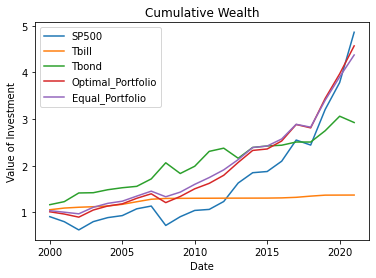

In [ ]:
df_cumret.plot(logy=False, title='Cumulative Wealth', xlabel='Date', ylabel='Value of Investment');

## <font color='red'>*Note the portfolios kept pace with stocks with less risk.* </font>

# CVXPY Optimizer (Two Asset Portfolio)

In [ ]:
import numpy as np
import cvxpy as cp

In [ ]:
# CMAs

risk_tolerance = risk_tol
risk_aversion = 1/(2*risk_tolerance)

exp_ret = exp_ret.reshape(-1,1)
exp_risk = exp_stdev.reshape(-1,1)
exp_corr = np.array([[1.,corr_stk_bnd],
                     [corr_stk_bnd,1.]])

In [ ]:
# Covariance Matrix

exp_cov = exp_risk.T*exp_corr*exp_risk
exp_cov

array([[ 0.03787129, -0.0003477 ],
       [-0.0003477 ,  0.00589805]])

In [ ]:
# Optimization Variables

weights = cp.Variable(len(exp_ret))                       # Portfolio weights (to be determined)

exp_ret_port = weights.T@exp_ret                          # Portfolio return

exp_risk_port = cp.quad_form(weights, exp_cov)            # Portfolio risk

utility = exp_ret_port - risk_aversion * exp_risk_port    # Utility function


In [ ]:
# Formulate MVO 

objective = cp.Maximize(utility)
 
constraints = [cp.sum(weights)==1, weights>=0]            # Includes no shorting constraint

In [ ]:
# Run Optimizer

problem = cp.Problem(objective, constraints)
problem.solve()
print('OPTIMAL PORTFOLIO')
print("status:", problem.status)
print(f'stock and bond weights = {weights.value*100}')
print(f'port ret = {exp_ret_port.value}')
print(f'port risk = {exp_risk_port.value**.5:.2f}')

OPTIMAL PORTFOLIO
status: optimal
stock and bond weights = [59.31899908 40.68100092]
port ret = [0.09090801]
port risk = 0.12
